In [1]:
import glog
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
import torch.nn.functional as F
from pytorch_lightning import seed_everything


sys.path.append('../..')

import xfinai_config
from data_layer.base_dataset import FuturesDatasetRecurrent
from utils import path_wrapper, plotter

### 0 Loading Data

In [2]:
seed = 416
seed_everything(seed)

future_index= 'ic'

params = {
    "epochs":10,
    "batch_size": 64,
    "hidden_size": 128,
    "seq_length": 32,
    "weight_decay": 0.03699014272607559,
    "num_layers": 2,
    "learning_rate": 0.001264079267383521,
#     "learning_rate": 0.0006264079267383521,
    "dropout_prob": 0.0049846528896436
#     "dropout_prob": 0.2149846528896436
}

I0320 17:28:23.551559 4020 seed.py:69] Global seed set to 416


In [3]:
# Load data
train_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_train_data.pkl")
val_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_val_data.pkl")
test_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_test_data.pkl")

In [4]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, device):
        super(GRU, self).__init__()

        self.name = 'GRU'
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.device = device
        self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers,
                          batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        batch_size = x.shape[0]
        h0 =  torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_(True).to(self.device)
        x, hn = self.gru(x, h0)
        x = self.fc1(x)
        return x[:, -1, :]

### 1 Define GRU Model

In [5]:
def eval_model(model, dataloader, data_set_name, future_name, params):
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])

        for idx, (x_batch, y_batch) in enumerate(dataloader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            y_pred = model(x_batch)

            y_real_list = np.append(y_real_list, y_batch.squeeze(1).cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.squeeze(1).cpu().numpy())

    plt.figure(figsize=[15, 3], dpi=100)
    plt.plot(y_real_list, label=f'{data_set_name}_real')
    plt.plot(y_pred_list, label=f'{data_set_name}_pred')
    plt.legend()
    plt.title(f"Inference On {data_set_name} Set - {model.name} {future_name}")
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.subplots_adjust(bottom=0.15)

    result_dir = path_wrapper.wrap_path(f"{xfinai_config.inference_result_path}/{future_name}/{model.name}")
    plt.savefig(f"{result_dir}/{data_set_name}.png")
    

def save_model(model, future_name):
    dir_path = path_wrapper.wrap_path(f"{xfinai_config.model_save_path}/{future_name}")
    save_path = f"{dir_path}/{model.name}.pth"
    glog.info(f"Starting save model state, save_path: {save_path}")
    torch.save(model.state_dict(), save_path)

### 2 Create Training Func

In [6]:
def train(train_data_loader, model, criterion, optimizer, params):
    
    # Set to train mode
    model.train()
    running_train_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(train_data_loader):
        optimizer.zero_grad()

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.float().to(model.device)

        # Make prediction
        y_pred = model(x_batch)

        # Calculate loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        running_train_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()


    train_loss_average = running_train_loss / len(train_data_loader)
    return model, train_loss_average

In [7]:
def validate(val_data_loader, model, criterion, params):
    # Set to eval mode
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():

        for idx, (x_batch, y_batch) in enumerate(val_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            y_pred = model(x_batch)

            val_loss = criterion(y_pred, y_batch)
            running_val_loss += val_loss.item()

    val_loss_average = running_val_loss / len(val_data_loader)
    return val_loss_average

### 3 Run Training

In [8]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create dataset & data loader
train_dataset = FuturesDatasetRecurrent(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
val_dataset = FuturesDatasetRecurrent(data=val_data, label=xfinai_config.label, seq_length=params['seq_length'])
test_dataset = FuturesDatasetRecurrent(data=test_data, label=xfinai_config.label, seq_length=params['seq_length'])
train_loader = DataLoader(dataset=train_dataset, **xfinai_config.data_loader_config,
                          batch_size=params['batch_size'])
val_loader = DataLoader(dataset=val_dataset, **xfinai_config.data_loader_config,
                        batch_size=params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, **xfinai_config.data_loader_config,
                         batch_size=params['batch_size'])

In [9]:

# create model instance
model = GRU(
    input_size=len(train_dataset.features_list),
    hidden_size=params['hidden_size'],
    num_layers=params['num_layers'],
    output_size=xfinai_config.model_config['gru']['output_size'],
    dropout_prob=params['dropout_prob'],
    device=device
).to(device)

criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])

epochs = params['epochs']

print(model)
train_losses = []
val_losses = []
# train the model
glog.info(f"Start Training Model")

for epoch in range(epochs):
    trained_model, train_score = train(train_data_loader=train_loader, model=model, criterion=criterion,
                                       optimizer=optimizer,
                                       params=params)
    val_score = validate(val_data_loader=val_loader, model=trained_model, criterion=criterion, params=params)

    # report intermediate result
    if (epoch+1) % 10 == 0:
        print(f"Epoch :{epoch} train_score {train_score} val_score {val_score}")
        
    train_losses.append(train_score)
    val_losses.append(val_score)
    
glog.info(f"End Training Model")

I0320 17:28:38.642822 4020 2418926776.py:2] Start Training Model


GRU(
  (gru): GRU(28, 128, num_layers=2, batch_first=True, dropout=0.0049846528896436)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)


I0320 17:28:44.963191 4020 2418926776.py:27] End Training Model
I0320 17:28:47.864596 4020 2418926776.py:2] Start Training Model
I0320 17:28:51.496595 4020 2418926776.py:27] End Training Model
I0320 17:28:54.129628 4020 2418926776.py:2] Start Training Model
I0320 17:28:57.803927 4020 2418926776.py:27] End Training Model
I0320 17:29:00.560683 4020 2418926776.py:2] Start Training Model
I0320 17:29:04.238126 4020 2418926776.py:27] End Training Model
I0320 17:29:06.752466 4020 2418926776.py:2] Start Training Model
I0320 17:29:10.234612 4020 2418926776.py:27] End Training Model
I0320 17:29:13.674099 4020 2418926776.py:2] Start Training Model
I0320 17:29:17.359591 4020 2418926776.py:27] End Training Model
I0320 17:29:19.937744 4020 2418926776.py:2] Start Training Model
I0320 17:29:23.356216 4020 2418926776.py:27] End Training Model
I0320 17:29:25.903027 4020 2418926776.py:2] Start Training Model
I0320 17:29:29.459452 4020 2418926776.py:27] End Training Model
I0320 17:29:31.893889 4020 241892

Epoch :9 train_score 3.0496956714369633e-05 val_score 0.00012620750140772072


I0320 17:30:07.034496 4020 2635015828.py:32] Starting save model state, save_path: D:/projects/XFinAI/model_layer/trained_models/ic/GRU.pth


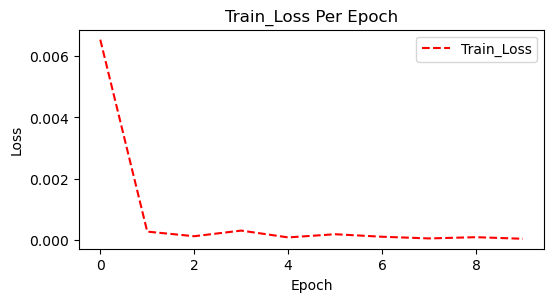

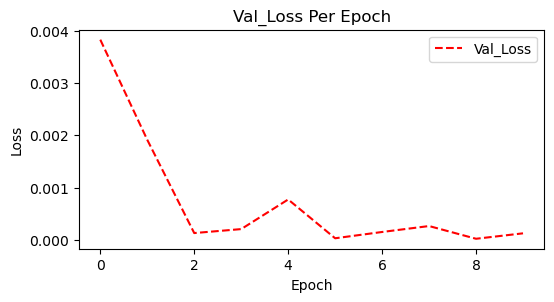

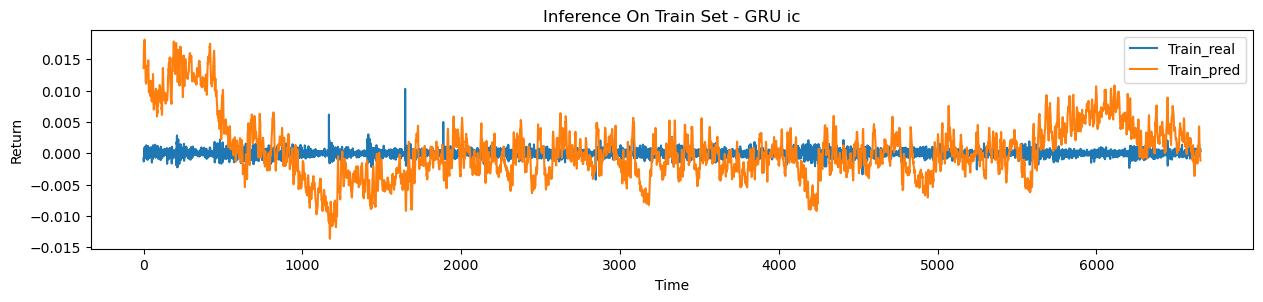

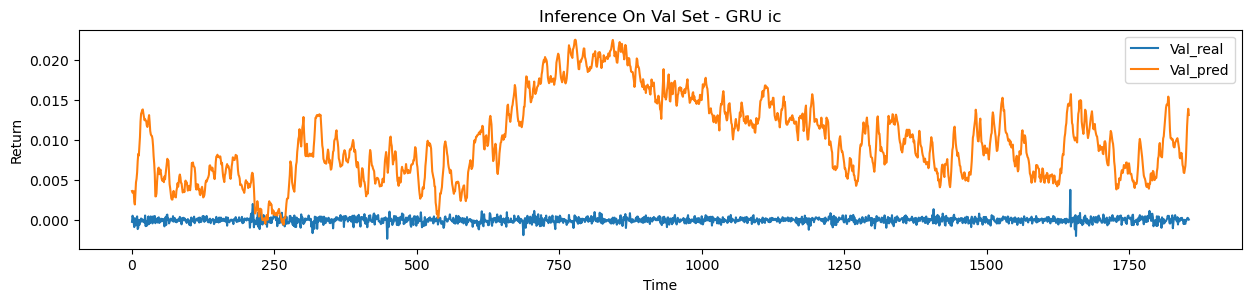

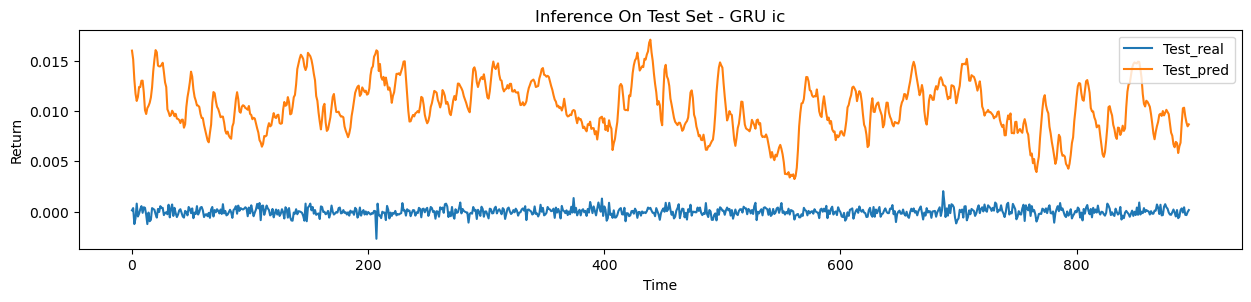

In [12]:

# # save the model
# save_model(trained_model, future_index)

# plot losses
plotter.plot_loss(train_losses, epochs, 'Train_Loss', trained_model.name, future_index)
plotter.plot_loss(val_losses, epochs, 'Val_Loss', trained_model.name, future_index)

# eval model on 3 datasets
for dataloader, data_set_name in zip([train_loader, val_loader, test_loader],
                                     ['Train', 'Val', 'Test']):
    eval_model(model=trained_model, dataloader=dataloader, data_set_name=data_set_name,
               future_name=future_index, params=params)
    
save_model(model,future_index)

In [11]:
save_model(model,future_index)

I0320 17:29:53.308568 4020 2635015828.py:32] Starting save model state, save_path: D:/projects/XFinAI/model_layer/trained_models/ic/GRU.pth
